**Importing Dataset**

In [78]:
import pandas as pd
import numpy as np

DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataframe = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = DATASET_ENCODING, names=DATASET_COLUMNS)
dataframe.head()
dataframe.drop(['ids','date','flag','user'], axis=1)
dataframe.head()


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**Dropping the redundant columns**

In [79]:
dataframe = dataframe.drop(['ids','date','flag','user'], axis=1)
dataframe.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


**Splitting of Dataset for Training and Testing**

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test,Y_train, Y_test = train_test_split(dataframe["text"],dataframe["target"] ,random_state=71, test_size=0.33, shuffle=True)
Y_test.value_counts()[4]

264198

**Removing the Stop words**

In [81]:
longStopWordsFile = open("longStopWords.txt","r",encoding='latin-1')
longStopWords = []
for line in longStopWordsFile:
    longStopWords.append(line.strip())

In [82]:
POSITIVE = 'positive'
NEGATIVE = 'negative'

**Cleaning Tweets**

In [83]:
from nltk.tokenize import RegexpTokenizer
import re
import string
import nltk
import operator
from nltk.stem import PorterStemmer

tokenizer = RegexpTokenizer(r'[\w\']+')
reviewText = []
uniqueWords = set()
words = []
lines=[]
stemmer = PorterStemmer()
wordsCounter = {POSITIVE:{},NEGATIVE:{}}
positive_tweets_count = 0
negative_tweets_count = 0

def pre_process_tweet(tweet):
    tweet=tweet.lower()
    tweet = re.sub('@[A-Za-z0-9_]+', '', tweet) #removes @mentions
    tweet = re.sub('#','',tweet) #removes hastag '#' symbol
    tweet = re.sub('RT[\s]+','',tweet)
    tweet = re.sub('https?:\/\/\S+', '', tweet) 
    tweet = re.sub('\n',' ',tweet)
    wordList = tokenizer.tokenize(tweet.strip())
    wordListTokenized=[]
    for word in wordList:
        if word not in longStopWords and word not in string.punctuation:
            if not word.isnumeric():
                word = stemmer.stem(word)
                wordListTokenized.append(word)

    return tweet, wordListTokenized

for i,tweet in enumerate(X_train):
    target = POSITIVE if (Y_train.iloc[i]>=2) else NEGATIVE
    tweet, wordList = pre_process_tweet(tweet=tweet)
    lines.append(wordList)
    if(target == POSITIVE):
        positive_tweets_count = positive_tweets_count + 1
    else:
        negative_tweets_count = negative_tweets_count + 1
    
    for word in wordList:
        words.append(word)
        uniqueWords.add(word)
        if(word in wordsCounter[target]):
            wordsCounter[target][word] = wordsCounter[target].get(word)+1
        else:
            wordsCounter[target][word] = 1

wordsCounter[POSITIVE]= dict( sorted(wordsCounter[POSITIVE].items(), key=operator.itemgetter(1),reverse=True))
wordsCounter[NEGATIVE]= dict( sorted(wordsCounter[NEGATIVE].items(), key=operator.itemgetter(1),reverse=True))



**Top 10 Positive Sentiment Words**

In [84]:
list(wordsCounter[POSITIVE].keys())[0:10]

['good', 'love', 'day', 'quot', 'lol', 'time', 'u', 'today', 'work', 'amp']

**Top 10 Negative Sentiment Words**

In [85]:
list(wordsCounter[NEGATIVE].keys())[0:10]

['work', 'day', 'today', 'feel', 'time', 'good', 'sad', 'quot', 'u', 'lol']

In [86]:
print(positive_tweets_count)
print(negative_tweets_count)

535802
536198


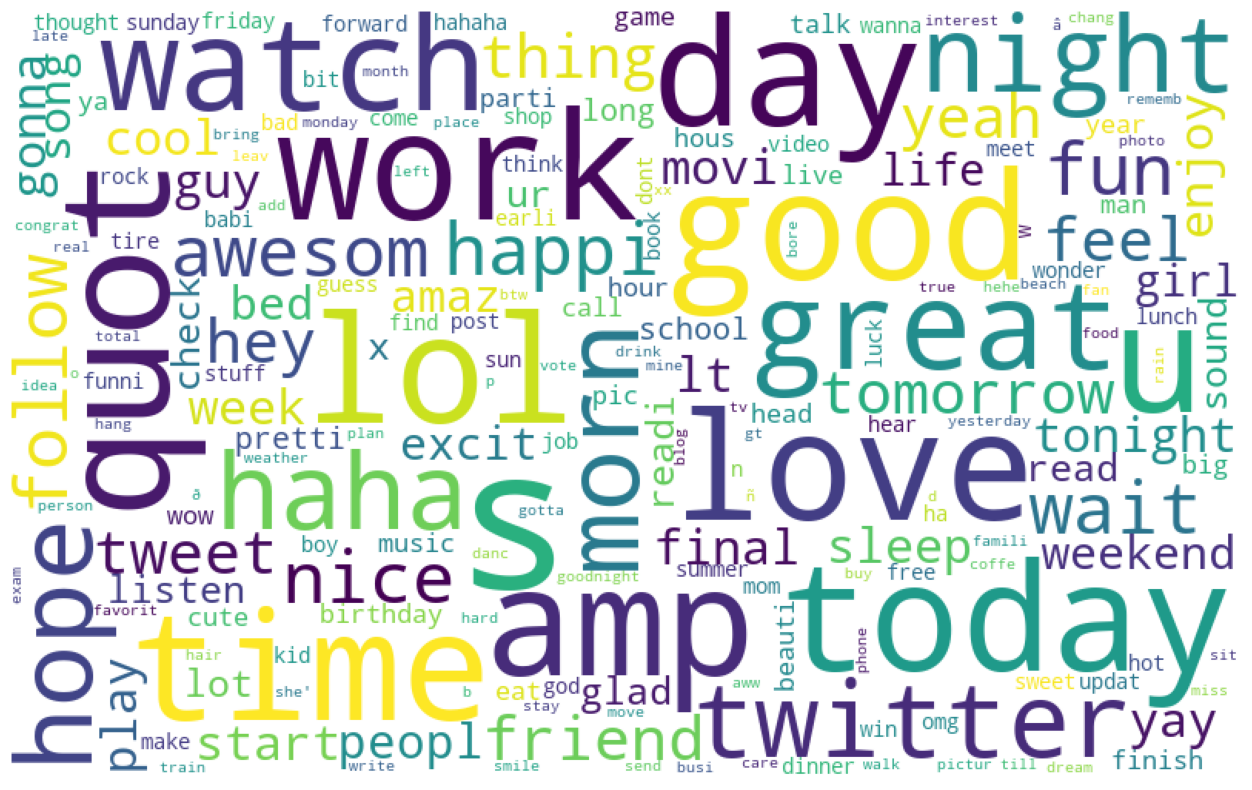

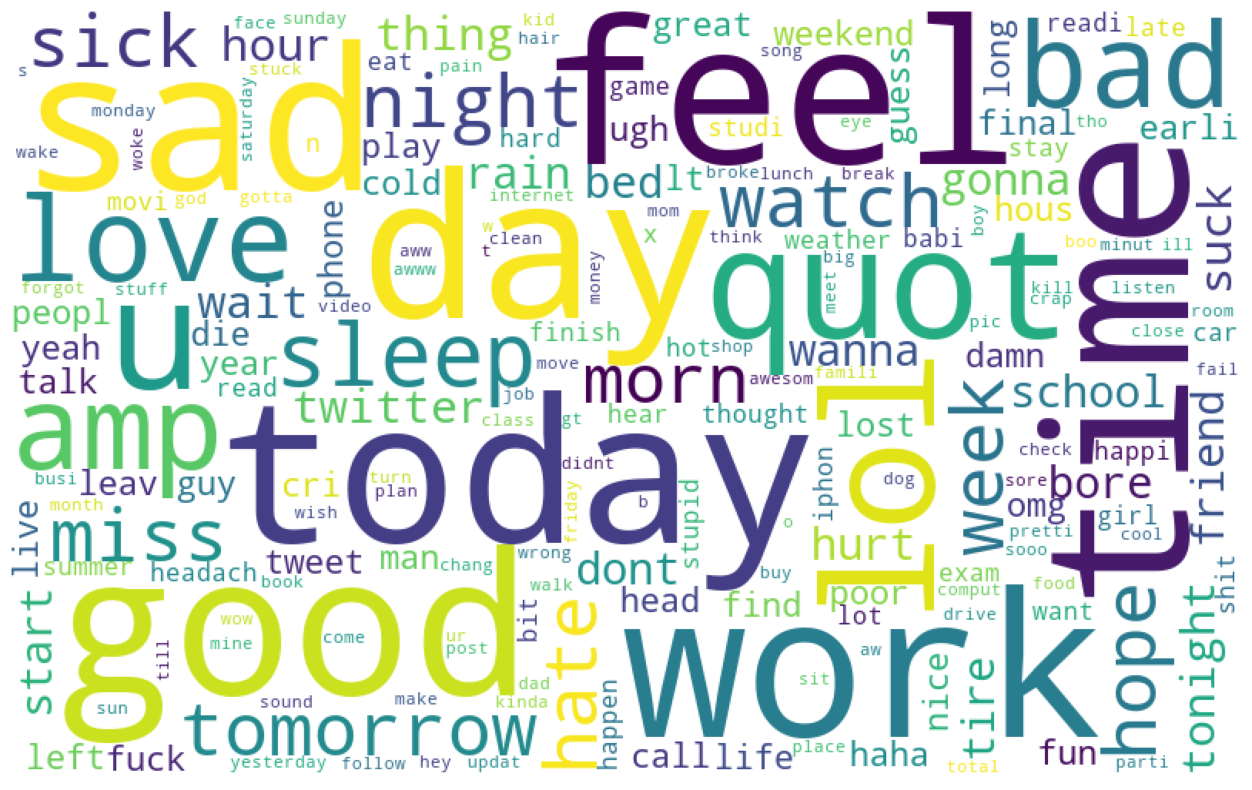

In [87]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def create_wordcloud(text):    
    allWords = ' '.join([tweets for tweets in text])
    wordCloud = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130).generate(allWords)
    plt.figure(figsize=(20,10))
    plt.imshow(wordCloud)
    plt.axis('off')
    plt.show()

# posTweets = savedTweets.loc[savedTweets['Analysis']=='Positive', 'cleanedTweets']
create_wordcloud(list(wordsCounter[POSITIVE].keys())[0:500])
create_wordcloud(list(wordsCounter[NEGATIVE].keys())[0:500])

**Calculating Likelihood for every word**

In [88]:
log_prior_probablity = np.log(positive_tweets_count) - np.log(negative_tweets_count)
log_prior_probablity

logLikelihood = {}

for word in uniqueWords:
    pos_freq = wordsCounter[POSITIVE][word] if word in wordsCounter[POSITIVE].keys() else 0
    neg_freq = wordsCounter[NEGATIVE][word] if word in wordsCounter[NEGATIVE].keys() else 0
    
    probablity_of_pos = (pos_freq+1)/(positive_tweets_count+len(uniqueWords))
    probablity_of_neg = (neg_freq+1)/(negative_tweets_count+len(uniqueWords))

    logLikelihood[word] = np.log(probablity_of_pos/probablity_of_neg)

In [89]:
list(logLikelihood.items())[10:20]

[('drivel', 0.5113632428595297),
 ('pengersss', -0.6926095614664063),
 ('panalo', 1.0991499077616487),
 ('hihooo', 0.6936847996534843),
 ('soundcheck', 0.39257970686956273),
 ('flawda', -1.0980746695745707),
 ('gbh', 0.6936847996534843),
 ('entretain', 0.6936847996534843),
 ('thanxx', 1.8331190828418493),
 ('obroni', 0.6936847996534843)]

**Top 10 Words with highest likelihood**

In [90]:
top_likelihood = dict( sorted(logLikelihood.items(), key=operator.itemgetter(1),reverse=True))
list(top_likelihood.items())[:10]

[('tweeterfollow', 6.091847501171237),
 ('tweeteradd', 5.651270872659925),
 ('iamsoannoy', 5.030975540485975),
 ('mileymonday', 4.804558663826795),
 ('longestpoemintheworld', 4.36998547156056),
 ('emailunlimit', 4.220045324269646),
 ('m2e', 4.043588886928089),
 ('shaunjumpnow', 3.8506852208035975),
 ('dividend', 3.418264302706905),
 ('psykoid', 3.4017350007556946)]

In [91]:
wrongPrediction = []
def naive_bayes_predict_single(tweet):
    tweet,wordsList = pre_process_tweet(tweet=tweet)
    prior_probab = log_prior_probablity
    print("Probab: ",prior_probab)
    for word in wordsList:
        if(word in logLikelihood):
            prior_probab = prior_probab + logLikelihood[word]
            print(word," : ",prior_probab)
    return prior_probab

**Naive Bayes Prediction**

In [92]:
wrongPrediction = []
def naive_bayes_predict(tweet):
    tweet,wordsList = pre_process_tweet(tweet=tweet)
    prior_probab = log_prior_probablity
    for word in wordsList:
        if(word in logLikelihood):
            prior_probab = prior_probab + logLikelihood[word]
    return prior_probab

In [93]:
positive_pred = 0
negative_pred= 0
for i, tweet in enumerate(X_test):

    probab = naive_bayes_predict(tweet=tweet)
    if(probab>0):
        positive_pred+=1
    else:
        negative_pred+=1
    if(probab > 0 and Y_test.iloc[i]<=3):
        wrongPrediction.append(str(Y_test.iloc[i])+" : "+ tweet)
    elif(probab<0 and Y_test.iloc[i]>=3):
        wrongPrediction.append(str(Y_test.iloc[i])+" : "+tweet)


print("Predictied Positives: ",positive_pred)
print("Predictied Negatives: ",negative_pred)
print("Actual Positives: ", Y_test.value_counts()[4])
print("Actual Negatives: ", Y_test.value_counts()[0])


Predictied Positives:  254770
Predictied Negatives:  273230
Actual Positives:  264198
Actual Negatives:  263802


In [94]:
positive_pred = 0
negative_pred= 0
TP=0
TN=0
FP=0
FN = 0
for i, tweet in enumerate(X_test):

    probab = naive_bayes_predict(tweet=tweet)
    if(probab>0):
        positive_pred+=1
    else:
        negative_pred+=1
    if(probab > 0 and Y_test.iloc[i]<=3):
        FP += 1
        # wrongPrediction.append(tweet)
    elif(probab<0 and Y_test.iloc[i]>=3):
        # wrongPrediction.append(tweet)
        FN += 1
    elif(probab > 0 and Y_test.iloc[i]>=3):
        TP+=1
    elif(probab < 0 and Y_test.iloc[i]<=3):
        TN+=1



print("Predictied Positives: ",positive_pred)
print("Predictied Negatives: ",negative_pred)
print("Actual Positives: ", Y_test.value_counts()[4])
print("Actual Negatives: ", Y_test.value_counts()[0])

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
fmeasure = (2*precision*recall)/(precision+recall)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F-Measure: ",fmeasure)

Predictied Positives:  254770
Predictied Negatives:  273230
Actual Positives:  264198
Actual Negatives:  263802
Accuracy:  0.7343181818181819
Precision:  0.7431958236841072
Recall:  0.7166746152506832
F-Measure:  0.7296943164125727


Predictied Positives:  229659
Predictied Negatives:  298341
Actual Positives:  264198
Actual Negatives:  263802

In [95]:
len(uniqueWords)

200581

In [96]:
train_matrix = list()
train_matrix = train_matrix.append(list(uniqueWords))
list(uniqueWords)
# train_matrix

['archufriend',
 "minehead'",
 "'a",
 'fucktard',
 'olyp',
 'jasperreport',
 'mmmhhhmmm',
 'fjã',
 'wrkshp',
 'correia',
 'drivel',
 'pengersss',
 'panalo',
 'hihooo',
 'soundcheck',
 'flawda',
 'gbh',
 'entretain',
 'thanxx',
 'obroni',
 'hahahahhaaha',
 'codignit',
 "harry'",
 'doigh',
 'constantin',
 'lenlow',
 'coullddnnt',
 'lifelink',
 'slago',
 'panarct',
 'dugger',
 'rachel',
 'asan',
 'ilusfdm',
 'friiend',
 'tabe',
 "rodriguez''",
 'puhleeeaass',
 '4bfast',
 '157cm',
 'izzybear',
 'slleep',
 'kasihmu',
 'plannng',
 'shitzuuuu',
 'seemingless',
 'stduy',
 'syna',
 'shawdi',
 'ttc',
 'hssm',
 "worker'09",
 'worsa',
 'willsim',
 'trickili',
 'awayyyyyyyi',
 '8ig',
 'blovesu87',
 'pleugh',
 'ketemu',
 'psda',
 'sleeeeeeeeeepi',
 'encorag',
 'kingdomheart',
 'waipio',
 "'kamalia'",
 'longman',
 'muï',
 'mistylamefac',
 'bummerrrrrrr',
 'bringiton',
 'jmap',
 'bournvita',
 'painswick',
 "rb'n",
 'whir',
 'esnä',
 'bliddi',
 'eeeeeeeee',
 'bbciplay',
 'aawwwwwwww',
 'onci',
 'outbac

In [97]:
uniqueWords_dict = {}
for i,word in enumerate(uniqueWords):
    uniqueWords_dict[word] = i
uniqueWords_dict

{'archufriend': 0,
 "minehead'": 1,
 "'a": 2,
 'fucktard': 3,
 'olyp': 4,
 'jasperreport': 5,
 'mmmhhhmmm': 6,
 'fjã': 7,
 'wrkshp': 8,
 'correia': 9,
 'drivel': 10,
 'pengersss': 11,
 'panalo': 12,
 'hihooo': 13,
 'soundcheck': 14,
 'flawda': 15,
 'gbh': 16,
 'entretain': 17,
 'thanxx': 18,
 'obroni': 19,
 'hahahahhaaha': 20,
 'codignit': 21,
 "harry'": 22,
 'doigh': 23,
 'constantin': 24,
 'lenlow': 25,
 'coullddnnt': 26,
 'lifelink': 27,
 'slago': 28,
 'panarct': 29,
 'dugger': 30,
 'rachel': 31,
 'asan': 32,
 'ilusfdm': 33,
 'friiend': 34,
 'tabe': 35,
 "rodriguez''": 36,
 'puhleeeaass': 37,
 '4bfast': 38,
 '157cm': 39,
 'izzybear': 40,
 'slleep': 41,
 'kasihmu': 42,
 'plannng': 43,
 'shitzuuuu': 44,
 'seemingless': 45,
 'stduy': 46,
 'syna': 47,
 'shawdi': 48,
 'ttc': 49,
 'hssm': 50,
 "worker'09": 51,
 'worsa': 52,
 'willsim': 53,
 'trickili': 54,
 'awayyyyyyyi': 55,
 '8ig': 56,
 'blovesu87': 57,
 'pleugh': 58,
 'ketemu': 59,
 'psda': 60,
 'sleeeeeeeeeepi': 61,
 'encorag': 62,
 '

**KNN Classification**

**Creating BoW for Training matrix**

In [98]:
train_matrix = []
for line in lines[0:10000]:
    temp_list = [0]*len(uniqueWords)
    for word in line:
        temp_list[uniqueWords_dict[word]] = temp_list[uniqueWords_dict[word]]+1
    train_matrix.append(temp_list)

**Creating BoW for Test matrix**

In [99]:
test_matrix = []
for line in lines[10000:11000]:
    temp_list = [0]*len(uniqueWords)
    for word in line:
        # print(uniqueWords_dict[word])
        temp_list[uniqueWords_dict[word]] = temp_list[uniqueWords_dict[word]]+1
    test_matrix.append(temp_list)

**Size of Test Matrix**

In [100]:
m_test,n_test = len(test_matrix), len(test_matrix[0])
m_test,n_test 

(1000, 200581)

**Size of Train Matrix**

In [101]:
m_train,n_train = len(train_matrix), len(train_matrix[0])
m_train,n_train 


(10000, 200581)

**Computing the Distance Matrix using Euclidian distance formula**

In [102]:
train_matrix = np.array(train_matrix)
test_matrix = np.array(test_matrix)
x2 = np.sum(train_matrix**2, axis=1) 
y2 = np.sum(test_matrix**2, axis=1)
xy = np.matmul(train_matrix, test_matrix.T)
x2 = x2.reshape(-1, 1)
dists = x2 - 2*xy + y2

In [103]:
dists = dists.T
dists.shape

(1000, 10000)

In [104]:
dists_dataframe = pd.DataFrame(dists)
dists_dataframe

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,7,9,9,8,6,7,25,14,15,5,...,4,9,11,12,10,4,8,11,6,11
1,5,7,7,6,4,5,23,12,13,3,...,2,7,9,10,8,2,6,9,4,9
2,7,9,9,8,6,7,25,14,15,5,...,4,9,11,12,10,4,8,11,6,11
3,7,9,9,8,6,7,25,14,15,5,...,4,9,11,12,10,4,8,11,6,11
4,7,9,9,8,6,7,25,14,15,5,...,4,9,11,12,10,4,8,11,6,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6,8,8,7,5,6,24,13,14,4,...,3,8,10,11,9,3,7,10,5,10
996,6,8,8,7,5,6,24,13,14,4,...,3,8,10,11,9,3,7,10,5,10
997,8,10,10,9,7,8,26,15,16,6,...,5,10,12,13,11,5,9,12,7,12
998,9,11,11,10,8,9,27,16,17,7,...,6,11,13,14,12,6,10,11,8,13


In [105]:
def drawGraphPls(data,Y_label):
    number_clusters = range(len(data))
    plt.plot(number_clusters, data)
    plt.xlabel('Number of Clusters')
    plt.ylabel(Y_label)
    plt.show()

**Computing metrics for 1 - 50 clusters**

In [106]:
import itertools

import progressbar

right = 0
wrong = 0
accuracy=list()
precision=list()
recall=list()
fmeasure = list()
k = 50

TP=0
TN=0
FP=0
FN=0
timerCount = 0
bar = progressbar.ProgressBar(maxval=k, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(k):
    Y_pred = []
    for ls in dists: 
        sorted_distances_indices = np.argsort(ls)
        knn_indices = []
        knn_indices = list(itertools.islice(sorted_distances_indices,i))
        positive_count = 0
        negative_count = 0
        for index in knn_indices:
            if Y_train.iloc[index] == 4:
                positive_count+=1
            else:
                negative_count+=1
        if(positive_count > negative_count):
            Y_pred.append(4)
        else:
            Y_pred.append(0)  

    right = 0
    wrong = 0
    for j,ele in enumerate(Y_train.iloc[10000:11000]):
        if(ele == 4 and Y_pred[j]==0):
            FP += 1
        elif(ele==0 and Y_pred[j]==4):
            FN += 1
        elif(ele ==4 and Y_pred[j]==4):
            TP+=1
        elif(ele == 0 and Y_pred[j]==0):
            TN+=1
    acc = (TP+TN)/(TP+TN+FP+FN)
    if(TP ==0 and FP ==0):
       prec = 0 
    else:
        prec = TP/(TP+FP)
    if(TP ==0 and FN ==0):
       rec = 0 
    else:
        rec = TP/(TP+FN)
    if(prec == 0.0 and rec == 0.0):
        fmeas = 0
    else:
        fmeas = (2*prec*rec)/(prec+rec)

    accuracy.append(acc)
    precision.append(prec)
    recall.append(rec)
    fmeasure.append(fmeas)
    bar.update(i+1)
bar.finish()


[========================================================================] 100%


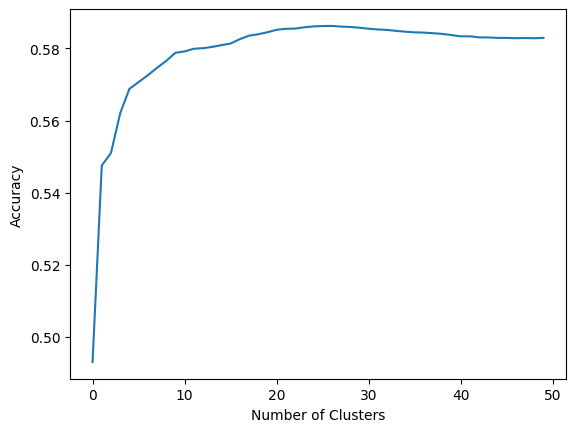

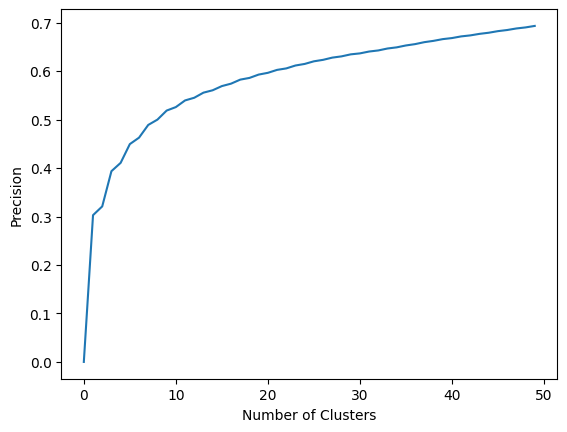

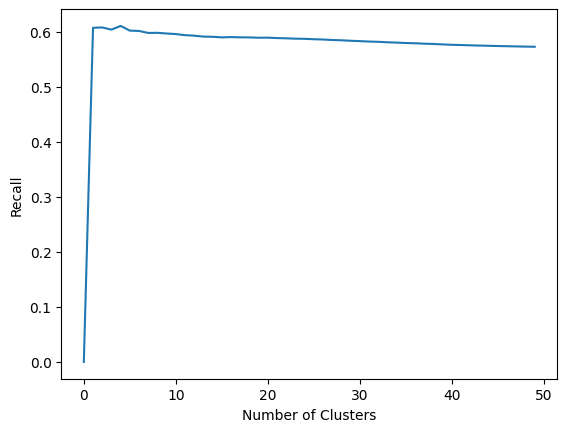

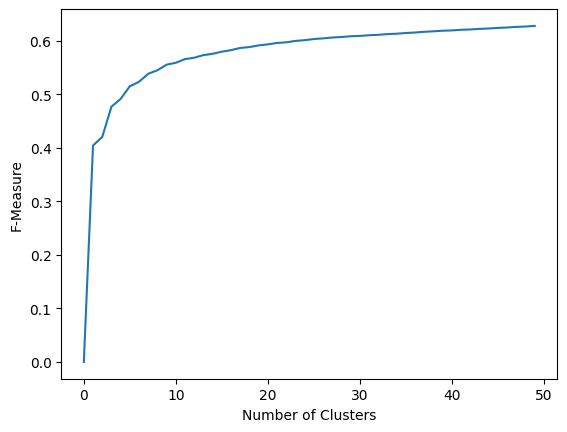

In [107]:
drawGraphPls(data=accuracy,Y_label='Accuracy')
drawGraphPls(data=precision,Y_label='Precision')
drawGraphPls(data=recall,Y_label='Recall')
drawGraphPls(data=fmeasure, Y_label='F-Measure')

In [108]:

Y_pred = []
for ls in dists: 
    sorted_distances_indices = np.argsort(ls)
    knn_indices = []
    knn_indices = list(itertools.islice(sorted_distances_indices,9))
    positive_count = 0
    negative_count = 0
    for index in knn_indices:
        if Y_train.iloc[index] == 4:
            positive_count+=1
        else:
            negative_count+=1
    if(positive_count > negative_count):
        Y_pred.append(4)
    else:
        Y_pred.append(0)

for j,ele in enumerate(Y_train.iloc[10000:11000]):
    if(ele == 4 and Y_pred[j]==0):
        FP += 1
    elif(ele==0 and Y_pred[j]==4):
        FN += 1
    elif(ele ==4 and Y_pred[j]==4):
        TP+=1
    elif(ele == 0 and Y_pred[j]==0):
        TN+=1
acc = (TP+TN)/(TP+TN+FP+FN)
prec = TP/(TP+FP)
rec = TP/(TP+FN)
fmeas = (2*prec*rec)/(prec+rec)

print("Accuracy: ",acc)
print("Precision: ", prec)
print("Recall: ",rec)
print("F-Measure: ",fmeas)

Accuracy:  0.5832549019607843
Precision:  0.6930425029972541
Recall:  0.5736786503185325
F-Measure:  0.627736714891232
